In [1]:
import numpy as np
import pandas as pd
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import fftpack
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
from sklearn.cluster import KMeans
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import igraph

%matplotlib inline

In [2]:
sns.set_palette('husl')

In [3]:
colormap = sns.palettes.diverging_palette(0, 150, n=20, l=90, center='dark', as_cmap=True)

In [4]:
minn = io.loadmat('../data/minnesota.mat')
Aroads = minn['Problem'][0][0][2]
xy = minn['Problem'][0][0][8][0][0][0]

numcomp, components = csgraph.connected_components(Aroads)
compsize = np.max(np.bincount(components))
biggestcomp = np.argmax(np.bincount(components))
in_component = np.where(components == biggestcomp)[0]

Aroads = Aroads.todense()
Aroads = Aroads[in_component][:, in_component]
Aroads = sparse.csc_matrix(Aroads)

xy = xy[in_component]

links = np.where(Aroads.todense())
startcoords = xy[links[0]]
endcoords = xy[links[1]]
lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

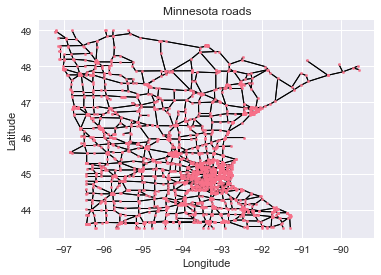

In [5]:
fig, ax = plt.subplots()

lc = collections.LineCollection(lines, linewidths=1, colors='k')

ax.add_collection(lc)
ax.scatter(xy[:, 0], xy[:, 1], s=6, zorder=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Minnesota roads')

In [6]:
tau = 15
hat = signal.ricker(1000, 100)[500:]

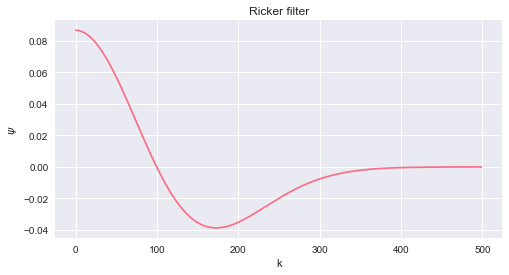

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(hat)
plt.xlabel('k')
plt.ylabel(r'$\psi$')
plt.title('Ricker filter')

In [8]:
def ckwt_wavelet(A, tau, h):
    '''
    A : adjacency matrix
    tau: scale factor
    h: continuous wavelet filter
    '''
    
    # Construct graph wavelet filter, W
    W = np.zeros(A.shape).astype(float)
    # Generate geodesic distances
    spath = csgraph.shortest_path(Aroads, directed=False, unweighted=True).astype(int)
    # Resample filter
    if not (h.size % tau):
        hm = h.reshape(tau, -1).mean(axis=1)
    else:
        hm = h[:-(h.size % tau)].reshape(tau, -1).mean(axis=1)
        
    for i in range(W.shape[0]):
        # N: histogram of distances from i
        # N_t: Number of vertices within k hops of i for all k < tau
        N = np.bincount(spath[i, :])
        N_t = np.where(spath[i, :] < tau, N[spath[i, :]], i)
        mask = (spath[i, :] < tau)
        # a : wavelet coefficients
        a = np.zeros_like(spath[i, :]).astype(float)
        a[mask] = hm[spath[i, :][mask]] / N_t[mask].astype(float)
        W[:, i] = a
    return W

In [9]:
W = ckwt_wavelet(Aroads, tau, hat)

In [10]:
# Generate localized piecewise graph signal
L = csgraph.laplacian(Aroads).todense()
l, u = np.linalg.eigh(L)
kmeans = KMeans(n_clusters=3, random_state=1).fit(u[:, :3])
g = np.where(kmeans.labels_ == 0, 1, 0) + 0.1*np.random.randn(Aroads.shape[0])

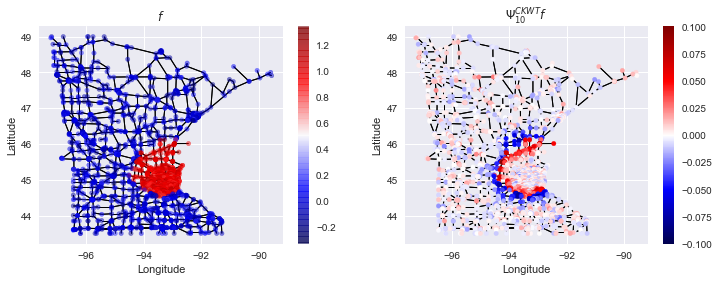

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

gg = W.T @ g

li = ax[0].add_collection(lc)
sc = ax[0].scatter(xy[:, 0], xy[:, 1], s=20, c=g, alpha=0.5,
                zorder=2, cmap='seismic', vmin=g.min(), vmax=g.max())
plt.colorbar(sc, ax=ax[0])

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax[1].add_collection(lc)
sc = ax[1].scatter(xy[:, 0], xy[:, 1], s=20, c=gg, alpha=1,
                zorder=2, cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar(sc, ax=ax[1])

ax[0].set_title(r'$f$')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].set_title(r'$\Psi_{10}^{CKWT} f$')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

In [12]:
tau = 4
W = ckwt_wavelet(Aroads, tau, hat)

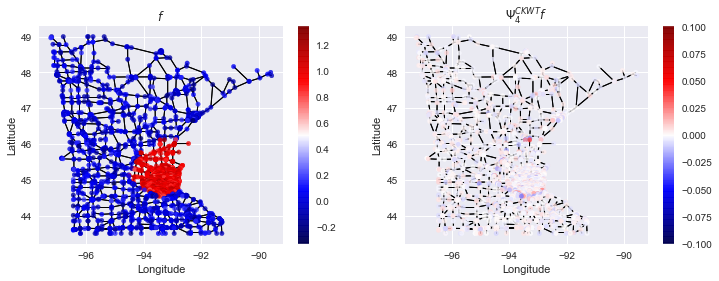

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

gg = W.T @ g

li = ax[0].add_collection(lc)
sc = ax[0].scatter(xy[:, 0], xy[:, 1], s=20, c=g, alpha=0.8,
                zorder=2, cmap='seismic', vmin=g.min(), vmax=g.max())
plt.colorbar(sc, ax=ax[0])

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax[1].add_collection(lc)
sc = ax[1].scatter(xy[:, 0], xy[:, 1], s=20, c=gg, alpha=0.8,
                zorder=2, cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar(sc, ax=ax[1])

ax[0].set_title(r'$f$')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].set_title(r'$\Psi_{4}^{CKWT} f$')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')